In [97]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import catboost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import joblib
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap

In [98]:
# CatBoost & load model
catboost_model = CatBoostClassifier()
catboost_model.load_model('../model/catboost_model')

# Grab importance
cb_df = pd.DataFrame(catboost_model.get_feature_importance(prettified=True))

cb_df.rename(
    columns={
        'Feature Id': 'Feature',
        'Importances': 'Importance'
    }, inplace = True
)

# Show user
cb_df

,Feature,Importance
0,AIRLINE,20.807725
1,ORIGIN_AIRPORT,19.695691
2,Scheduled Arrival Time,17.331703
3,DAY_OF_WEEK,16.350858
4,DESTINATION_AIRPORT,14.846843
5,DISTANCE,10.401902
6,Scheduled Hour,0.565278
7,MONTH,0.000000


In [99]:
# Plot to compare
cb_fig = px.bar(cb_df, x='Feature', y='Importance',
                title='CatBoost Model Feature Importance')

# Show
cb_fig.show()

In [100]:
# Random Forest Model
random_forest_model = joblib.load('../model/random_forest_model.joblib')

# Get feature names from the model
rfm_feature = random_forest_model.feature_names_in_

# Get importance values
rfm_importance = random_forest_model.feature_importances_

rfm_df = pd.DataFrame({
    'Feature': rfm_feature,
    'Importance': rfm_importance
})

# Sort by importance (descending)
rfm_df = rfm_df.sort_values('Importance', ascending=False)

# Show user
rfm_df


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:440: InconsistentVersionWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\base.py:440: InconsistentVersionWarning:

Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations



,Feature,Importance
4,Scheduled Arrival Time,0.250286
1,DAY_OF_WEEK,0.228204
2,DISTANCE,0.081183
3,Scheduled Hour,0.016098
632,AIRLINE_DL,0.010110
...,...,...
434,DESTINATION_AIRPORT_GFK,0.000007
13,ORIGIN_AIRPORT_ADK,0.000006
14,ORIGIN_AIRPORT_ADQ,0.000004
325,DESTINATION_AIRPORT_ADK,0.000003


In [101]:
# Plot to compare
rfm_fig = px.bar(rfm_df, x='Feature', y='Importance',
                title='Random Forest Model Feature Importance')

# Show user
rfm_fig.show()

In [102]:
# Limit it to top ten
rfm_fig = px.bar(rfm_df.head(10), x='Feature', y='Importance',
                title='Random Forest Model Feature Importance')

# Show user
rfm_fig.show()

In [103]:
# Initialize
aggregated = {}

# Grab the feature and importance and replace then with one to be combined
for column, row in rfm_df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    if feature.startswith('AIRLINE_'):
        category = 'AIRLINE'
    elif feature.startswith('ORIGIN_AIRPORT_'):
        category = 'ORIGIN_AIRPORT'
    elif feature.startswith('DESTINATION_AIRPORT_'):
        category = 'DESTINATION_AIRPORT'
    else:
        category = feature
    
    # Sum and combine
    aggregated[category] = aggregated.get(category, 0) + importance

# Turn to dataframe and sort by importance
aggregated = pd.DataFrame(
    list(aggregated.items()), 
    columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

# Show user
aggregated

,Feature,Importance
0,Scheduled Arrival Time,0.250286
1,DAY_OF_WEEK,0.228204
5,ORIGIN_AIRPORT,0.188267
6,DESTINATION_AIRPORT,0.176437
2,DISTANCE,0.081183
4,AIRLINE,0.059526
3,Scheduled Hour,0.016098
7,MONTH,0.000000


In [104]:
# Plot to compare
rfm_agg_fig = px.bar(aggregated, x='Feature', y='Importance',
                title='Random Forest Model Feature Importance (Aggregated)')

# Show user
rfm_agg_fig.show()

In [105]:
# Set indexes
aggregated_indexed = aggregated.set_index('Feature')
cb_df_indexed = cb_df.set_index('Feature')

# Align them
aggregated, cb_df = aggregated_indexed.align(cb_df_indexed, join = 'outer', axis = 0)

# Reset the inedx
aggregated.reset_index(inplace = True)
cb_df.reset_index(inplace = True)

In [106]:
# Make a comparison
compare_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the aggregated Random Forest Model
compare_fig.add_trace(
    go.Bar(x=aggregated['Feature'], y=aggregated['Importance'],
           opacity = 0.7, name = 'Random Forest Model'),
    secondary_y=False
)

# Add the CatBoost Model
compare_fig.add_trace(
    go.Bar(x=cb_df['Feature'], y=cb_df['Importance'],
           opacity = 0.7, name = 'CatBoost Model'),
    secondary_y=True
)

# Add titles and sort
compare_fig.update_layout(
    title_text = 'Comparison of Feature Importance Between Random Forest Model and CatBoost Model',
    xaxis = {'categoryorder': 'total descending'}
)


# Show user
compare_fig.show()

In [120]:
catboost_load = catboost.CatBoost()
catboost_load.load_model('../model/catboost_model')
explainer = shap.TreeExplainer(catboost_load)

In [ ]:
# Read
df = pd.read_csv('../data/01-raw/flights.csv')

# Date things
df['Date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df['Schedule Delay'] = df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']

# If it's NA, then the flight was cancelled
df.dropna(subset= ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'Schedule Delay'], inplace = True)

# Convert the time
df['Scheduled Hour'] = (df['SCHEDULED_TIME'] // 100).astype(int)
df['Scheduled Arrival Time'] = (df['SCHEDULED_ARRIVAL'] // 100).astype(int)

# Categorize it, where 15m is usually considered the standard if a flight is delayed or not
df['Delayed or not'] = np.where(
    (df['DEPARTURE_DELAY'] < 15) & (df['ARRIVAL_DELAY'] < 15),
    'Not delayed',
    'Delayed'
)

# Convert to 0 and 1
df['Is_Delayed'] = (df['Delayed or not'] == 'Delayed').astype(int)

# Force cast to float
df['DISTANCE'] = df['DISTANCE'].astype(float)

# Sample so it doesn't crash
model_feature_order = catboost_load.feature_names_
feature_list = cb_df['Feature'].tolist()
sample_df = df[model_feature_order].sample(n=1000).copy()
sample_df

C:\Users\user\AppData\Local\Temp\ipykernel_8304\3187352988.py:1: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.



,MONTH,DAY_OF_WEEK,DISTANCE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,AIRLINE,Scheduled Hour,Scheduled Arrival Time
864589,2,4,1489.0,MCI,SEA,AS,2,18
1001103,3,6,337.0,BNA,CMH,WN,0,12
4557411,10,7,190.0,14698,14771,OO,0,21
5175306,11,5,829.0,IND,MCO,WN,1,8
2536512,6,3,266.0,BTV,JFK,B6,0,7
...,...,...,...,...,...,...,...,...
3719110,8,3,283.0,BWI,BDL,WN,0,14
1673548,4,5,601.0,MDW,DCA,WN,1,18
4797438,10,2,463.0,11618,11066,EV,1,8
5139667,11,2,1062.0,DEN,MSY,WN,1,23


In [109]:
shap.initjs()

In [ ]:
# Get values
shap_values = explainer(sample_df)
shap.plots.force(shap_values[:, :, 0])

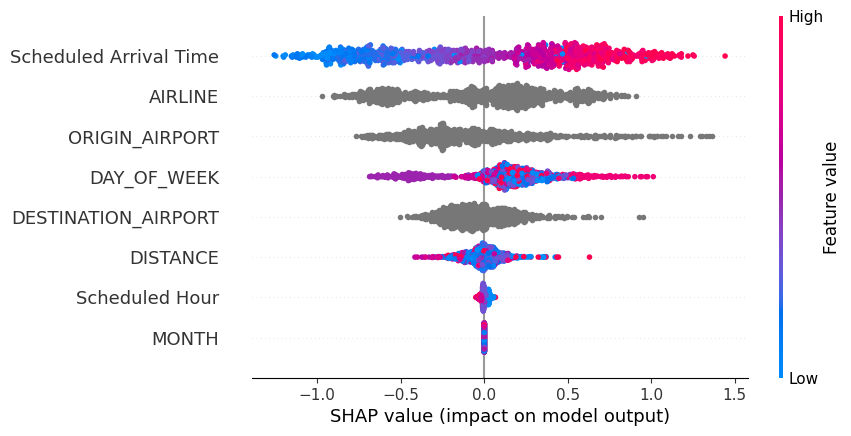

In [ ]:
# Bee Swarm
shap.plots.beeswarm(shap_values[:, :, 0])